#  data loader camus PyTorch

In [1]:
from torchvision import transforms
import torchvision
import cv2
import skimage.io as io
from PIL import Image
import torch
from torch import nn
import os
from datetime import datetime
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import json
from glob import glob
import sys
import datetime
from torchvision.utils import save_image

In [2]:
RANDOM_SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(RANDOM_SEED)

In [3]:
with open('configs/ventricle.json') as f:
    config = json.load(f)

In [4]:
config['NAME']

'ventricle'

In [5]:
!ls ../../datasets/CAMUS/training/patient0001

Info_2CH.cfg		      patient0001_2CH_sequence.raw
Info_4CH.cfg		      patient0001_4CH_ED_gt.mhd
patient0001_2CH_ED_gt.mhd     patient0001_4CH_ED_gt.raw
patient0001_2CH_ED_gt.raw     patient0001_4CH_ED.mhd
patient0001_2CH_ED.mhd	      patient0001_4CH_ED.raw
patient0001_2CH_ED.raw	      patient0001_4CH_ES_gt.mhd
patient0001_2CH_ES_gt.mhd     patient0001_4CH_ES_gt.raw
patient0001_2CH_ES_gt.raw     patient0001_4CH_ES.mhd
patient0001_2CH_ES.mhd	      patient0001_4CH_ES.raw
patient0001_2CH_ES.raw	      patient0001_4CH_sequence.mhd
patient0001_2CH_sequence.mhd  patient0001_4CH_sequence.raw


## empty folders patient0451 - patient0500

In [6]:
!ls ../../datasets/CAMUS/training/patient0451

ls: cannot access '../../datasets/CAMUS/training/patient0451': No such file or directory


In [7]:
!find ../../datasets/CAMUS/training/ -type d -empty -print

In [8]:
!find ../../datasets/CAMUS/training/ -type d -empty -delete

In [9]:
!find ../../datasets/CAMUS/training/ -type d -empty -print

In [10]:
class Dataset(Dataset):
    def __init__(self, dataset_path, input_name, target_name, condition_name,
                 img_res, target_rescale, input_rescale, condition_rescale, 
                 train_ratio, valid_ratio, labels, augment, subset='train'):

        self.dataset_path = dataset_path
        self.img_res = tuple(img_res)
        self.target_rescale = target_rescale
        self.input_rescale = input_rescale
        self.condition_rescale = condition_rescale
        self.input_name = input_name
        self.target_name = target_name
        self.condition_name = condition_name
        self.augment = augment
        self.items = []
    
        patients = sorted(glob(os.path.join(self.dataset_path, 'training', '*')))
        
        for patient in patients:
            path = patient
            head, patient_id = os.path.split(path)
            target_path = os.path.join(path, '{}_{}.mhd'.format(patient_id, self.target_name))
            condition_path = os.path.join(path, '{}_{}.mhd'.format(patient_id, self.condition_name))
            input_path = os.path.join(path, '{}_{}.mhd'.format(patient_id, self.input_name))
            self.items.append((target_path, condition_path, input_path))

        
        random.Random().shuffle(self.items)
        num = len(self.items)

        all_labels = {0, 1, 2, 3}
        self.not_labels = all_labels - set(labels)

        if subset == 'train':
            self.items = self.items[: int(train_ratio * num)]
        elif subset == 'valid':
            self.items = self.items[int(train_ratio * num): int(train_ratio * num) + int(valid_ratio * num)]
        elif subset == 'test':
            self.items = self.items[int(train_ratio * num) + int(valid_ratio * num):]
        
    
    def read_mhd(self, img_path, is_gt):
        
        #if not os.path.exists(img_path): # empty folders
        #    print(img_path)
        #    #return np.zeros(self.img_res + (1,))
        #    return np.zeros(self.img_res)
        img = io.imread(img_path, plugin='simpleitk').squeeze()

        img = np.array(Image.fromarray(img).resize(self.img_res))

        if is_gt:
            for not_l in self.not_labels:
                img[img == not_l] = 0
        return img
    
    def get_weight_map(self, mask):
        # let the y axis have higher variance
        gauss_var = [[self.img_res[0] * 60, 0], [0, self.img_res[1] * 30]]
        # print(mask.shape) # (256, 256) or (256, 256, 1) for empty
        #if len(mask.shape) > 2:
        #    mask = np.squeeze(mask, axis=2)
        #    
        x, y = mask.nonzero()
        
        
        center = [x.mean(), y.mean()]
   

        from scipy.stats import multivariate_normal
        gauss = multivariate_normal.pdf(np.mgrid[
                                        0:self.img_res[1],
                                        0:self.img_res[0]].reshape(2, -1).transpose(),
                                        mean=center,
                                        cov=gauss_var)
        
        gauss /= gauss.max()
        gauss = gauss.reshape((self.img_res[1], self.img_res[0]))


        # set the gauss value of the main target part to 1
        gauss[mask > 0] = 1


        return gauss
    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        target_path, condition_path, input_path = self.items[index]
        
        target = self.read_mhd(img_path = target_path, is_gt = True)#.astype(float)
        condition = self.read_mhd(img_path = condition_path, is_gt = True)
        input_ = self.read_mhd(img_path = input_path, is_gt = False)

        
        weight_map_condition = self.get_weight_map(condition)#.astype(float)
        #weight_map_condition = transforms.ToTensor()(weight_map_condition)
        weight_map_condition = torch.tensor(np.asarray(weight_map_condition)).float().unsqueeze(dim=0)
        input_ = torch.tensor(np.asarray(input_)).float().unsqueeze(dim=0)
        condition = torch.tensor(np.asarray(condition)).float().unsqueeze(dim=0)
        
        target = transforms.ToTensor()(target)
        
        return target, condition, input_, weight_map_condition


In [11]:
augmentation = dict()
for key, value in config.items():
    if 'AUG_' in key:
        augmentation[key] = value

In [12]:
augmentation

{'AUG_TARGET': False,
 'AUG_INPUT': False,
 'AUG_ROTATION_RANGE_DEGREES': 0,
 'AUG_WIDTH_SHIFT_RANGE_RATIO': 0.0,
 'AUG_HEIGHT_SHIFT_RANGE_RATIO': 0.0,
 'AUG_SHEAR_RANGE_ANGLE': 0,
 'AUG_ZOOM_RANGE_RATIO': 0.0}

In [13]:
train_data = Dataset(dataset_path='../../datasets/CAMUS/', 
                     input_name=config['INPUT_NAME'],
                     target_name=config['TARGET_NAME'],
                     condition_name=config['CONDITION_NAME'],
                     img_res=config['IMAGE_RES'],
                     target_rescale=config['TARGET_TRANS'],
                     input_rescale=config['INPUT_TRANS'],
                     condition_rescale=config['CONDITION_TRANS'],
                     labels=config['LABELS'],
                     train_ratio=0.95,
                     valid_ratio=0.02,
                     augment=augmentation,
                     subset='test')

In [14]:
train_data.__len__()

14

In [15]:
target, condition, input_, weight_map_condition = train_data[0]

In [16]:
print(target.shape)
print(condition.shape)
print(input_.shape)
print(weight_map_condition.shape)

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])


In [17]:
print(target.dtype)
print(condition.dtype)
print(input_.dtype)
print(weight_map_condition.dtype)

torch.float32
torch.float32
torch.float32
torch.float32


In [18]:
print(target.min(), target.max())
print(condition.min(), condition.max())
print(input_.min(), input_.max())
print(weight_map_condition.min(), weight_map_condition.max())

tensor(0.) tensor(0.9451)
tensor(0.) tensor(1.)
tensor(0.) tensor(3.)
tensor(0.1419) tensor(1.)


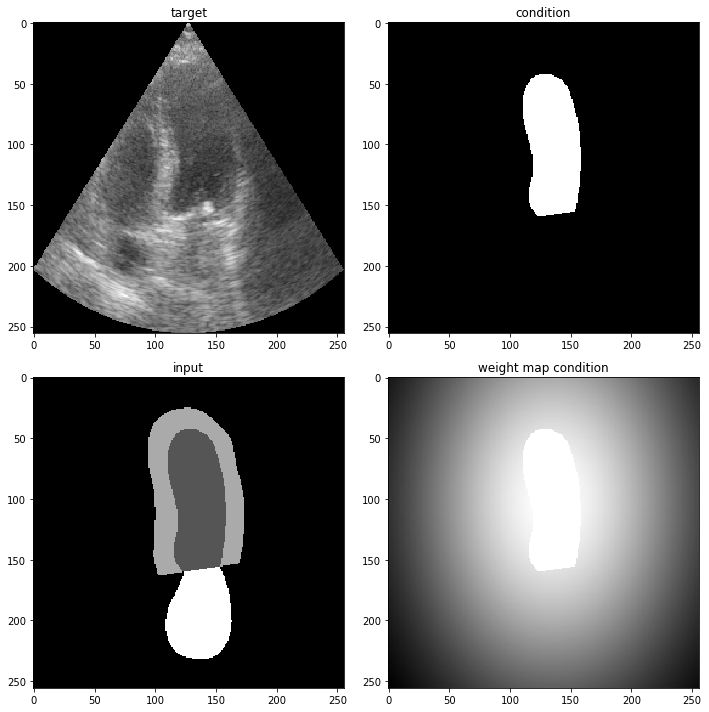

In [19]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.title('target')
plt.imshow(target[0], cmap='gray')

plt.subplot(2, 2, 2)
plt.title('condition')
plt.imshow(condition[0], cmap='gray')

plt.subplot(2, 2, 3)
plt.title('input')
plt.imshow(input_[0], cmap='gray')

plt.subplot(2, 2, 4)
plt.title('weight map condition')
plt.imshow(weight_map_condition[0], cmap='gray')
plt.tight_layout()

In [20]:
train_data = Dataset(dataset_path='../../datasets/CAMUS/', 
                     input_name=config['INPUT_NAME'],
                     target_name=config['TARGET_NAME'],
                     condition_name=config['CONDITION_NAME'],
                     img_res=config['IMAGE_RES'],
                     target_rescale=config['TARGET_TRANS'],
                     input_rescale=config['INPUT_TRANS'],
                     condition_rescale=config['CONDITION_TRANS'],
                     labels=config['LABELS'],
                     train_ratio=0.95,
                     valid_ratio=0.02,
                     augment=augmentation,
                     subset='train')

valid_data = Dataset(dataset_path='../../datasets/CAMUS/', 
                     input_name=config['INPUT_NAME'],
                     target_name=config['TARGET_NAME'],
                     condition_name=config['CONDITION_NAME'],
                     img_res=config['IMAGE_RES'],
                     target_rescale=config['TARGET_TRANS'],
                     input_rescale=config['INPUT_TRANS'],
                     condition_rescale=config['CONDITION_TRANS'],
                     labels=config['LABELS'],
                     train_ratio=0.95,
                     valid_ratio=0.02,
                     augment=augmentation,
                     subset='valid')

test_data = Dataset(dataset_path='../../datasets/CAMUS/', 
                     input_name=config['INPUT_NAME'],
                     target_name=config['TARGET_NAME'],
                     condition_name=config['CONDITION_NAME'],
                     img_res=config['IMAGE_RES'],
                     target_rescale=config['TARGET_TRANS'],
                     input_rescale=config['INPUT_TRANS'],
                     condition_rescale=config['CONDITION_TRANS'],
                     labels=config['LABELS'],
                     train_ratio=0.95,
                     valid_ratio=0.02,
                     augment=augmentation,
                     subset='test')

In [21]:
train_data.__len__(), valid_data.__len__(), test_data.__len__()

(427, 9, 14)

In [22]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=32, 
                                           shuffle=True,
                                           num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=8, 
                                           shuffle=False,
                                           num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=8, 
                                          shuffle=False,
                                          num_workers=4)

In [23]:
targets, conditions, inputs, weight_maps_conditions = next(iter(valid_loader))

In [24]:
targets.shape, conditions.shape, inputs.shape, weight_maps_conditions.shape

(torch.Size([8, 1, 256, 256]),
 torch.Size([8, 1, 256, 256]),
 torch.Size([8, 1, 256, 256]),
 torch.Size([8, 1, 256, 256]))

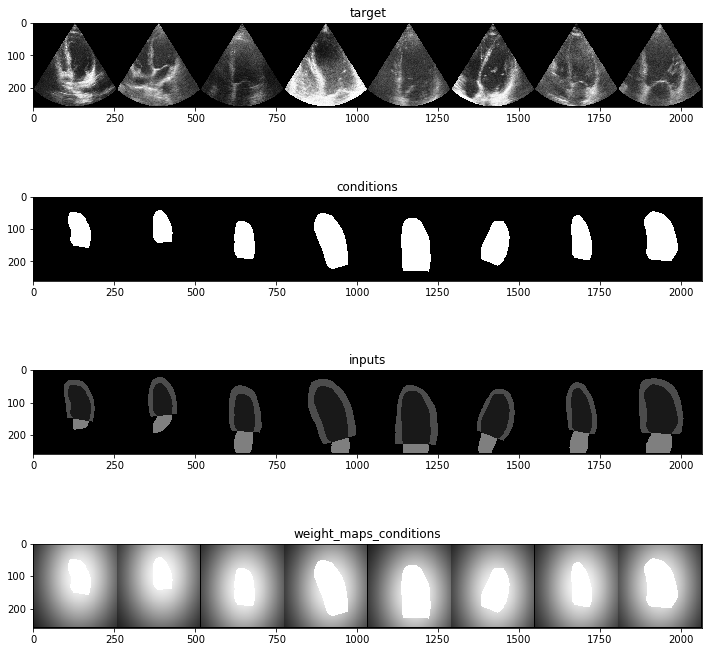

In [25]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.title('target')
plt.imshow(torchvision.utils.make_grid(targets).numpy().transpose(1,2,0))

plt.subplot(4, 1, 2)
plt.title('conditions')
plt.imshow(torchvision.utils.make_grid(conditions).float().numpy().transpose(1,2,0))

plt.subplot(4, 1, 3)
plt.title('inputs')
inputs[inputs == 1.] = 0.1
inputs[inputs == 2.] = 0.3
inputs[inputs == 3.] = 0.5
plt.imshow(torchvision.utils.make_grid(inputs).numpy().transpose(1,2,0))

plt.subplot(4, 1, 4)
plt.title('weight_maps_conditions')
plt.imshow(torchvision.utils.make_grid(weight_maps_conditions).numpy().transpose(1,2,0));
plt.tight_layout()

# model

In [26]:
from torch import nn
import torch.nn.functional as F
import torch

In [27]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


##############################
#           U-NET
##############################


class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x


class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, condition, target):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((condition, target), 1)
        return self.model(img_input)

In [28]:
generator = GeneratorUNet()
discriminator = Discriminator()

In [29]:
generator

GeneratorUNet(
  (down1): UNetDown(
    (model): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (down2): UNetDown(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down3): UNetDown(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down4): UNetDown(
    (model): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=Fals

In [30]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [32]:
# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss() # MAE
#criterion_pixelwise = torch.nn.L1Loss(reduction='none') # MAE

In [33]:
# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

In [34]:
# Calculate output of image discriminator (PatchGAN)
patch = (1, 256 // 2 ** 4, 256 // 2 ** 4)
patch

(1, 16, 16)

In [35]:
generator = generator.to(device)
discriminator = discriminator.to(device)

In [36]:
criterion_GAN.to(device)
criterion_pixelwise.to(device)

L1Loss()

In [37]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.00013, betas=(0.5, 0.999))#0.0002
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00015, betas=(0.5, 0.999))

In [38]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [39]:
# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [40]:
def sample_images(batches_done):
    """Saves a generated sample from the validation set"""
    imgs = next(iter(valid_loader))
    #real_A = Variable(imgs["B"].type(Tensor))
    #real_B = Variable(imgs["A"].type(Tensor))
    condition = imgs[0].to(device)
    real_echo = imgs[1].to(device)
    fake_echo = generator(condition)
    img_sample = torch.cat((condition.data, fake_echo.data, real_echo.data), -2)
    save_image(img_sample, "images/%s.png" % (batches_done), nrow=4, normalize=True)

In [41]:
import time
from torch.autograd import Variable

In [42]:
#Tensor = torch.cuda.FloatTensor if device else torch.FloatTensor

In [43]:
RESULT_DIR = 'results'
VAL_DIR = 'val_images'
TEST_DIR = 'test_images'
MODELS_DIR = 'saved_models'

In [44]:
epochs = 1000

In [ ]:
prev_time = time.time()

for epoch in range(epochs):
    for i, batch in enumerate(train_loader):
        target, condition, input_, weight_map_condition = batch

        condition = condition.to(device)
        real_echo = target.to(device)
        input_ = input_.to(device)
        weight_map_condition = weight_map_condition.to(device)


        # Adversarial ground truths

        valid = torch.tensor(np.ones((condition.size(0), *patch)) , dtype=torch.float32, device=device)
        #valid = Variable(torch.from_numpy(np.ones((real_A.size(0), *patch)).astype(float)).to(device), requires_grad=False)
        #fake = Variable(torch.from_numpy(np.zeros((real_A.size(0), *patch)).astype(float)).to(device), requires_grad=False)
        fake = torch.tensor(np.zeros((condition.size(0), *patch)) , dtype=torch.float32, device=device)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        fake_echo = generator(condition)
        pred_fake = discriminator(fake_echo, condition)
        loss_GAN = criterion_GAN(pred_fake, fake)#valid

        # Pixel-wise loss
        #loss_pixel = torch.mean(criterion_pixelwise(fake_echo, real_echo) * weight_map_condition)
        loss_pixel = criterion_pixelwise(fake_echo, real_echo)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(real_echo, condition)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_echo.detach(), condition)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(train_loader) + i
        batches_left = epochs * len(train_loader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f] ETA: %s"
            % (
                epoch,
                epochs,
                i,
                len(train_loader),
                loss_D.item(),
                loss_G.item(),
                loss_pixel.item(),
                loss_GAN.item(),
                time_left,
            )
        )
        # If at sample interval save image
        if batches_done % 100 == 0:
            sample_images(batches_done)



[Epoch 187/1000] [Batch 13/14] [D loss: 0.004473] [G loss: 4.720805, pixel: 0.047168, adv: 0.004037] ETA: 1:10:40.652201